In [13]:
# TODO:
# 1. matching if not all keypoints (added flag to the kps (the third dim))
%matplotlib inline
num = 13
base_dir = "Photos3"
extns = ["jpeg", "jpg"]

In [14]:
import glob, os
os.chdir(base_dir)
files = []
for f in [file for ext in extns for file in glob.glob("*.%s" % ext)]:
#     print(f)
    files.append(base_dir + "/" + f)
        
os.chdir("../")

In [15]:
import tensorflow as tf
import numpy as np
from PIL import Image
import pickle
import matplotlib.pyplot as plt
import cv2 as cv
#from google.colab.patches import cv2_imshow
import math
import matplotlib.pyplot as plt

In [16]:

def parse_output(heatmap_data,offset_data, threshold):
    '''      
    Input:
        heatmap_data - hetmaps for an image. Three dimension array
        offset_data - offset vectors for an image. Three dimension array
        threshold - probability threshold for the keypoints. Scalar value
      Output:
        array with coordinates of the keypoints and flags for those that have
        low probability
    '''
    joint_num = heatmap_data.shape[-1]
    pose_kps = np.zeros((joint_num,3), np.uint32)

    for i in range(heatmap_data.shape[-1]):

        joint_heatmap = heatmap_data[...,i]
        max_val_pos = np.squeeze(np.argwhere(joint_heatmap==np.max(joint_heatmap)))
        remap_pos = np.array(max_val_pos/8*257,dtype=np.int32)
        pose_kps[i,0] = int(remap_pos[0] + offset_data[max_val_pos[0],max_val_pos[1],i])
        pose_kps[i,1] = int(remap_pos[1] + offset_data[max_val_pos[0],max_val_pos[1],i+joint_num])
        max_prob = np.max(joint_heatmap)

        if max_prob > threshold:
            if pose_kps[i,0] < 257 and pose_kps[i,1] < 257:
                pose_kps[i,2] = 1

    return pose_kps

def draw_kps(show_img,kps, ratio=None):
    for i in range(5,kps.shape[0]):
        if kps[i,2]:
            if isinstance(ratio, tuple):
                cv.circle(show_img,(int(round(kps[i,1]*ratio[1])),int(round(kps[i,0]*ratio[0]))),2,(0,255,255),round(int(1*ratio[1])))
            continue
        cv.circle(show_img,(kps[i,1],kps[i,0]),2,(0,255,255),1)
    return show_img


def angle_length(p1, p2):
    '''
    Input:
        p1 - coordinates of point 1. List
        p2 - coordinates of point 2. List
    Output:
        Tuple containing the angle value between the line formed by two input points 
        and the x-axis as the first element and the length of this line as the second
        element
    '''
    angle = math.atan2(- int(p2[0]) + int(p1[0]), int(p2[1]) - int(p1[1])) * 180.0 / np.pi
    length = math.hypot(int(p2[1]) - int(p1[1]), - int(p2[0]) + int(p1[0]))
  
    return round(angle), round(length)



def draw_pose(img, keypoints, pairs):
    for i, pair in enumerate(pairs):
        color = (0,255,0)

        cv.line(img, (keypoints[pair[0]][1], keypoints[pair[0]][0]), (keypoints[pair[1]][1], keypoints[pair[1]][0]), color=color, lineType=cv.LINE_AA, thickness=1)

In [17]:
model_path = "posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite"

# Load TFLite model and allocate tensors (memory usage method reducing latency)
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get input and output tensors information from the model file
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
height = input_details[0]['shape'][1]
width = input_details[0]['shape'][2]

# parts to compare
parts_to_compare = [(5,6),(5,7),(6,8),(7,9),(8,10),(11,12),(5,11),(6,12),(11,13),(12,14),(13,15),(14,16)]


for file in files:
    template_path = file
    template_name_full = template_path.split('/')[-1]
    template_name_Xext = template_name_full.split(".")[0]
    # Create target directory & all intermediate directories if don't exists
    newdir = base_dir + "/" + template_name_Xext
    try:
        os.makedirs(newdir)    
#         print("Directory " , newdir ,  " Created ")
    except FileExistsError:
        pass
#         print("Directory " , newdir ,  " already exists")  
    try:
        # new file prefix path: without the extention and suffix of the name
        prefixPath = newdir + "/" + template_name_Xext
        template_image_src = cv.imread(template_path)
        src_tepml_width, src_templ_height, _ = template_image_src.shape 
        template_image = cv.resize(template_image_src, (width, height))
        cv.imwrite(prefixPath+"[original].jpg", template_image)

        # can be used later to draw keypoints on the source image (before resizing)
        templ_ratio_width = src_tepml_width/width
        templ_ratio_height = src_templ_height/height

        # add a new dimension to match model's input
        template_input = np.expand_dims(template_image.copy(), axis=0)

        # check the type of the input tensor
        floating_model = input_details[0]['dtype'] == np.float32

        if floating_model:
            template_input = (np.float32(template_input) - 127.5) / 127.5

        # Process template image
        # Sets the value of the input tensor
        interpreter.set_tensor(input_details[0]['index'], template_input)
        # Runs the computation
        interpreter.invoke()
        # Extract output data from the interpreter
        template_output_data = interpreter.get_tensor(output_details[0]['index'])
        template_offset_data = interpreter.get_tensor(output_details[1]['index'])
        # Getting rid of the extra dimension
        template_heatmaps = np.squeeze(template_output_data)
        template_offsets = np.squeeze(template_offset_data)
        print("template_heatmaps' shape:", template_heatmaps.shape)
        print("template_offsets' shape:", template_offsets.shape)

        # The output consist of 2 parts:
        # - heatmaps (9,9,17) - corresponds to the probability of appearance of 
        # each keypoint in the particular part of the image (9,9)(without applying sigmoid 
        # function). Is used to locate the approximate position of the joint
        # - offset vectors (9,9,34) is called offset vectors. Is used for more exact
        #  calculation of the keypoint's position. First 17 of the third dimension correspond
        # to the x coordinates and the second 17 of them correspond to the y coordinates

        template_show = np.squeeze((template_input.copy()*127.5+127.5)/255.0)
        template_show = np.array(template_show*255,np.uint8)
        template_kps = parse_output(template_heatmaps,template_offsets,0.8)

        # Matching by angles and proportions 
        # Matching keypoints indices in the output of PoseNet
        # 0. Left shoulder to right shoulder (5-6)
        # 1. Left shoulder to left elbow (5-7)
        # 2. Right shoulder to right elbow (6-8)
        # 3. Left elbow to left wrist (7-9)
        # 4. Right elbow to right wrist (8-10)
        # 5. Left hip to right hip (11-12)
        # 6. Left shoulder to left hip (5-11)
        # 7. Right shoulder to right hip (6-12)
        # 8. Left hip to left knee (11-13)
        # 9. Right hip to right knee (12-14)
        # 10. Left knee to left ankle (13-15)
        # 11.  Right knee to right ankle (14-16)
        template_values = []
        for part in parts_to_compare:
            template_values.append(angle_length(template_kps[part[0]][:2], template_kps[part[1]][:2]))

        draw_pose(template_show, template_kps, parts_to_compare)
        cv.imwrite(prefixPath+"[original+pose].jpg", template_show)

        # finding the pose as a template
        # Get a zero matrix with the shape of the template image
        template_pose = np.zeros_like(template_show)
        # connect some of the points 
        def join_point(img, kps):

            body_parts = [(5,6),(5,7),(6,8),(7,9),(8,10),(11,12),(5,11),
                              (6,12),(11,13),(12,14),(13,15),(14,16)]

            for part in body_parts:
                cv.line(img, (kps[part[0]][1], kps[part[0]][0]), (kps[part[1]][1], kps[part[1]][0]), 
                    color=(255,255,255), lineType=cv.LINE_AA, thickness=3)

        # draw a skeleton of the template pose to the empty image
        join_point(template_pose, template_kps[:, :2])
        # save the template
        cv.imwrite(prefixPath+"[pose-template].jpg", template_pose)
    
    except Exception:
        continue

template_heatmaps' shape: (9, 9, 17)
template_offsets' shape: (9, 9, 34)
template_heatmaps' shape: (9, 9, 17)
template_offsets' shape: (9, 9, 34)
template_heatmaps' shape: (9, 9, 17)
template_offsets' shape: (9, 9, 34)
template_heatmaps' shape: (9, 9, 17)
template_offsets' shape: (9, 9, 34)
template_heatmaps' shape: (9, 9, 17)
template_offsets' shape: (9, 9, 34)
template_heatmaps' shape: (9, 9, 17)
template_offsets' shape: (9, 9, 34)
template_heatmaps' shape: (9, 9, 17)
template_offsets' shape: (9, 9, 34)
template_heatmaps' shape: (9, 9, 17)
template_offsets' shape: (9, 9, 34)
template_heatmaps' shape: (9, 9, 17)
template_offsets' shape: (9, 9, 34)
template_heatmaps' shape: (9, 9, 17)
template_offsets' shape: (9, 9, 34)
template_heatmaps' shape: (9, 9, 17)
template_offsets' shape: (9, 9, 34)
template_heatmaps' shape: (9, 9, 17)
template_offsets' shape: (9, 9, 34)
template_heatmaps' shape: (9, 9, 17)
template_offsets' shape: (9, 9, 34)
template_heatmaps' shape: (9, 9, 17)
template_offse

In [3]:
# Steps for running:
# 1. Download PoseNet model from https://www.tensorflow.org/lite/models/pose_estimation/overview
# 2. Choose your template and target image to process
# 3. Specify paths

In [4]:
model_path = "posenet_mobilenet_v1_100_257x257_multi_kpt_stripped.tflite"
template_path = "person%d.jpg"%num
# target_path = "person_sit.jpeg"

In [5]:
# Load TFLite model and allocate tensors (memory usage method reducing latency)
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

In [6]:
# Get input and output tensors information from the model file
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

height = input_details[0]['shape'][1]
width = input_details[0]['shape'][2]

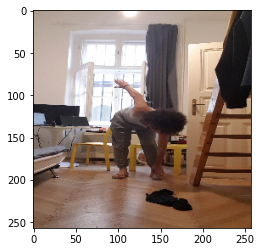

In [7]:
template_image_src = cv.imread(template_path)
src_tepml_width, src_templ_height, _ = template_image_src.shape 
template_image = cv.resize(template_image_src, (width, height))
cv.imwrite(templ, template_image)
# cv.imshow("image", template_image)
# cv.waitKey(3000)

plt.imshow(cv.cvtColor(template_image, cv.COLOR_BGR2RGB))

In [8]:
# can be used later to draw keypoints on the source image (before resizing)
templ_ratio_width = src_tepml_width/width
templ_ratio_height = src_templ_height/height

In [9]:
# target_image_src = cv.imread(target_path)
# src_tar_width, src_tar_height, _ = target_image_src.shape 
# target_image = cv.resize(target_image_src, (width, height))
# # cv.imshow("image", target_image)
# # cv.waitKey(0)
# plt.imshow(cv.cvtColor(target_image, cv.COLOR_BGR2RGB))

In [10]:
# tar_ratio_width = src_tar_width/width
# tar_ratio_height = src_tar_height/height

In [11]:
# add a new dimension to match model's input
template_input = np.expand_dims(template_image.copy(), axis=0)
# target_input = np.expand_dims(target_image.copy(), axis=0)

In [12]:
# check the type of the input tensor
floating_model = input_details[0]['dtype'] == np.float32

In [13]:
# Floating point models offer the best accuracy, at the expense of model size 
# and performance. GPU acceleration requires the use of floating point models.

# Brings input values to range from 0 to 1

In [14]:
if floating_model:
    template_input = (np.float32(template_input) - 127.5) / 127.5
#     target_input = (np.float32(target_input) - 127.5) / 127.5

In [15]:
# Process template image
# Sets the value of the input tensor
interpreter.set_tensor(input_details[0]['index'], template_input)
# Runs the computation
interpreter.invoke()
# Extract output data from the interpreter
template_output_data = interpreter.get_tensor(output_details[0]['index'])
template_offset_data = interpreter.get_tensor(output_details[1]['index'])
# Getting rid of the extra dimension
template_heatmaps = np.squeeze(template_output_data)
template_offsets = np.squeeze(template_offset_data)
print("template_heatmaps' shape:", template_heatmaps.shape)
print("template_offsets' shape:", template_offsets.shape)

template_heatmaps' shape: (9, 9, 17)
template_offsets' shape: (9, 9, 34)


In [16]:
# # Process target image. Same commands
# interpreter.set_tensor(input_details[0]['index'], target_input)
# interpreter.invoke()
# target_output_data = interpreter.get_tensor(output_details[0]['index'])
# target_offset_data = interpreter.get_tensor(output_details[1]['index'])
# target_heatmaps = np.squeeze(target_output_data)
# target_offsets = np.squeeze(target_offset_data)

In [17]:
# The output consist of 2 parts:
# - heatmaps (9,9,17) - corresponds to the probability of appearance of 
# each keypoint in the particular part of the image (9,9)(without applying sigmoid 
# function). Is used to locate the approximate position of the joint
# - offset vectors (9,9,34) is called offset vectors. Is used for more exact
#  calculation of the keypoint's position. First 17 of the third dimension correspond
# to the x coordinates and the second 17 of them correspond to the y coordinates

In [18]:
  '''
  Input:
    heatmap_data - hetmaps for an image. Three dimension array
    offset_data - offset vectors for an image. Three dimension array
    threshold - probability threshold for the keypoints. Scalar value
  Output:
    array with coordinates of the keypoints and flags for those that have
    low probability
  '''
def parse_output(heatmap_data,offset_data, threshold):
    joint_num = heatmap_data.shape[-1]
    pose_kps = np.zeros((joint_num,3), np.uint32)

    for i in range(heatmap_data.shape[-1]):

        joint_heatmap = heatmap_data[...,i]
        max_val_pos = np.squeeze(np.argwhere(joint_heatmap==np.max(joint_heatmap)))
        remap_pos = np.array(max_val_pos/8*257,dtype=np.int32)
        pose_kps[i,0] = int(remap_pos[0] + offset_data[max_val_pos[0],max_val_pos[1],i])
        pose_kps[i,1] = int(remap_pos[1] + offset_data[max_val_pos[0],max_val_pos[1],i+joint_num])
        max_prob = np.max(joint_heatmap)

        if max_prob > threshold:
            if pose_kps[i,0] < 257 and pose_kps[i,1] < 257:
                pose_kps[i,2] = 1

    return pose_kps

In [19]:
def draw_kps(show_img,kps, ratio=None):
    for i in range(5,kps.shape[0]):
        if kps[i,2]:
            if isinstance(ratio, tuple):
                cv.circle(show_img,(int(round(kps[i,1]*ratio[1])),int(round(kps[i,0]*ratio[0]))),2,(0,255,255),round(int(1*ratio[1])))
            continue
        cv.circle(show_img,(kps[i,1],kps[i,0]),2,(0,255,255),1)
    return show_img

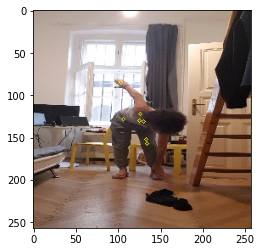

In [20]:
template_show = np.squeeze((template_input.copy()*127.5+127.5)/255.0)
template_show = np.array(template_show*255,np.uint8)
template_kps = parse_output(template_heatmaps,template_offsets,0.3)
# cv.imshow("image", draw_kps(template_show.copy(),template_kps))
plt.imshow(cv.cvtColor(draw_kps(template_show.copy(),template_kps), cv.COLOR_BGR2RGB))

In [21]:
# target_show = np.squeeze((target_input.copy()*127.5+127.5)/255.0)
# target_show = np.array(target_show*255,np.uint8)
# target_kps = parse_output(target_heatmaps,target_offsets,0.3)
# # cv2_imshow(draw_kps(target_show.copy(),target_kps))
# plt.imshow(cv.cvtColor(draw_kps(target_show.copy(),target_kps), cv.COLOR_BGR2RGB))

### Matching by angles and proportions

#### Set template values

In [22]:
# Matching keypoints indices in the output of PoseNet
# 0. Left shoulder to right shoulder (5-6)
# 1. Left shoulder to left elbow (5-7)
# 2. Right shoulder to right elbow (6-8)
# 3. Left elbow to left wrist (7-9)
# 4. Right elbow to right wrist (8-10)
# 5. Left hip to right hip (11-12)
# 6. Left shoulder to left hip (5-11)
# 7. Right shoulder to right hip (6-12)
# 8. Left hip to left knee (11-13)
# 9. Right hip to right knee (12-14)
# 10. Left knee to left ankle (13-15)
# 11.  Right knee to right ankle (14-16)

In [23]:
parts_to_compare = [(5,6),(5,7),(6,8),(7,9),(8,10),(11,12),(5,11),(6,12),(11,13),(12,14),(13,15),(14,16)]

In [87]:
def angle_length(p1, p2):
    '''
  Input:
    p1 - coordinates of point 1. List
    p2 - coordinates of point 2. List
  Output:
    Tuple containing the angle value between the line formed by two input points 
    and the x-axis as the first element and the length of this line as the second
    element
    '''
    angle = math.atan2(- int(p2[0]) + int(p1[0]), int(p2[1]) - int(p1[1])) * 180.0 / np.pi
    length = math.hypot(int(p2[1]) - int(p1[1]), - int(p2[0]) + int(p1[0]))
  
    return round(angle), round(length)

In [25]:
template_values = []
for part in parts_to_compare:
    template_values.append(angle_length(template_kps[part[0]][:2], template_kps[part[1]][:2]))
template_values

[(45, 1),
 (-90, 7),
 (-77, 31),
 (116, 50),
 (-79, 5),
 (-7, 24),
 (-165, 20),
 (-66, 10),
 (-96, 30),
 (-76, 30),
 (-88, 30),
 (-86, 28)]

In [26]:
# target_values = []
# for part in parts_to_compare:
#     target_values.append(angle_length(target_kps[part[0]][:2], target_kps[part[1]][:2]))
# target_values

In [27]:
# with open('template.pkl', 'wb') as f:
#   pickle.dump(template, f)

In [28]:
# with open('template.pkl', 'rb') as f:
#   template = pickle.load(f)

#### Matching

In [29]:
'''Input:
      1. template_kp - list of tuples (for the template image) containng angles 
      between particular body parts and x-axis as first elements and its sizes 
      (distances between corresponding points as second elements)
      2. target_kp - same for the target image
      3. angle_deviation - acceptable angle difference between corresponding 
      body parts in the images
      4. size_deviation - acceptable proportions difference between the images
    Output:
      List of body parts which are deviated
  '''

def matching(template_kp, target_kp, angle_deviation=30, size_deviation=1):
    devs = []

  # set an anchor size for proportions calculations - distance between shoulders
    templ_anchor = template_kp[0][1]
    targ_anchor = target_kp[0][1]

  # for each body part that we calculated angle and size for
    for i in range(len(template_kp)):

        angles = (template_kp[i][0], target_kp[i][0])
        diff_angle = max(angles) - min(angles)

        templ_size = (template_kp[i][1],templ_anchor)
        templ_size = abs(min(templ_size) / max(templ_size))

        tar_size = (target_kp[i][1], targ_anchor)
        tar_size = abs(min(tar_size) / max(tar_size))

        if diff_angle > angle_deviation:
            devs.append(i)
            print("{0} has different angle".format(i))

        elif max(tar_size,templ_size) - min(tar_size,templ_size) > size_deviation:
            devs.append(i)
            print("{0} has different size".format(i))

    return devs

In [30]:
# deviations = matching(template_values, target_values)
# deviations

#### Draw deviations

In [31]:
def draw_deviations(img, keypoints, pairs, deviations):
    for i, pair in enumerate(pairs):

        if i in deviations:
            color = (0,0,255)
        else:
            color = (0,255,0)

        cv.line(img, (keypoints[pair[0]][1], keypoints[pair[0]][0]), (keypoints[pair[1]][1], keypoints[pair[1]][0]), color=color, lineType=cv.LINE_AA, thickness=1)

In [32]:
def draw_pose(img, keypoints, pairs):
    for i, pair in enumerate(pairs):
        color = (0,255,0)

        cv.line(img, (keypoints[pair[0]][1], keypoints[pair[0]][0]), (keypoints[pair[1]][1], keypoints[pair[1]][0]), color=color, lineType=cv.LINE_AA, thickness=1)

In [33]:
# draw_deviations(template_show, template_kps, parts_to_compare, deviations)
draw_pose(template_show, template_kps, parts_to_compare)

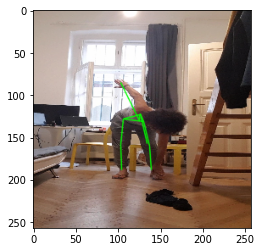

In [34]:
#cv2_imshow(target_show)
plt.imshow(cv.cvtColor(template_show, cv.COLOR_BGR2RGB))

In [35]:
cv.imwrite('persone%d-with pose.jpg'%num, template_show)

True

### Matching by finding the target pose in the image

#### Set a target pattern

In [36]:
# Get a zero matrix with the shape of the template image
template_pose = np.zeros_like(template_show)

In [37]:
# connect some of the points 
def join_point(img, kps):

    body_parts = [(5,6),(5,7),(6,8),(7,9),(8,10),(11,12),(5,11),
                      (6,12),(11,13),(12,14),(13,15),(14,16)]

    for part in body_parts:
        cv.line(img, (kps[part[0]][1], kps[part[0]][0]), (kps[part[1]][1], kps[part[1]][0]), 
            color=(255,255,255), lineType=cv.LINE_AA, thickness=3)


In [38]:
# draw a skeleton of the template pose to the empty image
join_point(template_pose, template_kps[:, :2])

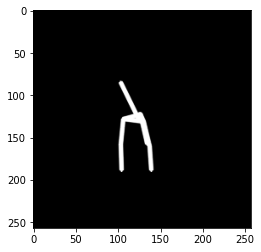

In [39]:
# cv2_imshow(template_pose)
plt.imshow(cv.cvtColor(template_pose, cv.COLOR_BGR2RGB))

In [40]:
# set the new dimensions of the image to reduce the size
buffer = 5 # size of the area around the pose
top_left_y = min(template_kps[5:, 0]) - buffer
top_left_x = min(template_kps[5:, 1]) - buffer
buttom_right_y = max(template_kps[5:, 0]) + buffer
buttom_right_x = max(template_kps[5:, 1]) + buffer

In [41]:
# crop the template pose with new dimensions
template_pose = template_pose[top_left_y:buttom_right_y, top_left_x:buttom_right_x]

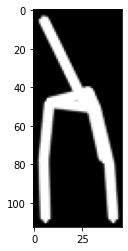

In [42]:
# cv2_imshow(template_pose)
plt.imshow(cv.cvtColor(template_pose, cv.COLOR_BGR2RGB))

In [43]:
# save the template pattern
cv.imwrite('template_pose%d.jpg'%num, template_pose)

True

#### Find the pattern in the new image

In [44]:
# Get a zero matrix with the shape of the target image
# target_pose = np.zeros_like(target_show)

In [45]:
# draw a skeleton of the target pose to the empty image
# join_point(target_pose, target_kps[:, :2])

In [46]:
# set the new dimensions of the image to reduce the size
# buffer = 5 # size of the area around the pose
# top_left_y = min(target_kps[5:, 0]) - buffer
# top_left_x = min(target_kps[5:, 1]) - buffer
# buttom_right_y = max(target_kps[5:, 0]) + buffer
# buttom_right_x = max(target_kps[5:, 1]) + buffer

In [47]:
# target_pose = target_pose[top_left_y:buttom_right_y, top_left_x:buttom_right_x]

In [48]:
# cv2_imshow(target_pose)
# plt.imshow(cv.cvtColor(target_pose, cv.COLOR_BGR2RGB))

In [49]:
# template_pose = cv.cvtColor(template_pose, cv.COLOR_BGR2GRAY)
# target_pose = cv.cvtColor(target_pose, cv.COLOR_BGR2GRAY)

In [50]:
# the greater the threshold the more exact the pose has to match
# threshold = 0.1

# w, h = target_pose.shape[::-1]
# res = cv.matchTemplate(target_pose,template_pose, cv.TM_CCOEFF_NORMED)
# score = res.max()

# print("score:", score)

# if score >= threshold:
#     print("Match")
# else:
#     print("Don't match")

### Draw grid

In [51]:
def draw_grid(img, grid_size=9, heatmap=None, part=1):

    color = (0,255,255)

    small_size = min(img.shape[0], img.shape[1])
    cell_size = small_size // grid_size
    res = int(small_size % grid_size)

    x = res // 2
    y = res // 2

    while x < img.shape[1]:
        cv.line(img, (x, 0), (x, img.shape[0]), color=color, lineType=cv.LINE_AA, thickness=1)
        x += cell_size

    while y < img.shape[0]:
        cv.line(img, (0, y), (img.shape[1], y), color=color, lineType=cv.LINE_AA, thickness=1)
        y += cell_size

    center_x = res//2
    center_y = res//2 + cell_size//2

    cv.putText(image,str(round(heatmap[0,0,part],1)), (center_x,center_y), cv.FONT_HERSHEY_SIMPLEX, 0.3, color)

    for row_idx, row in enumerate(heatmap[...,part]):

        for col_idx, column in enumerate(row):
            cv.putText(image,str(round(heatmap[col_idx,row_idx,part],1)), (center_x,center_y), cv.FONT_HERSHEY_SIMPLEX, 0.3, color)
            center_y += cell_size
        
        center_x += cell_size
        center_y = res//2 + cell_size//2

In [52]:
image = cv.imread('person%d.jpg'%num)
image = cv.resize(image, (257, 257)) 

In [53]:
draw_grid(image, 9, template_heatmaps)

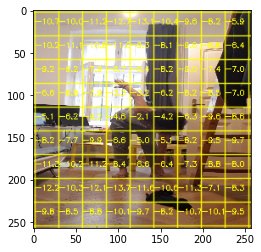

In [54]:
# cv2_imshow(image)
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

In [55]:
# cv.imwrite('image%d.jpg'%num, image)